In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import missingno as msno

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, classification_report, precision_recall_curve
from sklearn import metrics

from transformers import DFStandardScaler, DFIterativeImputer, DFSimpleImputer

import h2o
from h2o.frame import H2OFrame
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
Dir_PATH = ''
File_PATH = Dir_PATH + 'data_challenge_dataset.csv'
df = pd.read_csv(File_PATH)

## Quick Look

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Class
0,NaN,-0.072781,2.536347,NaN,-0.338321,0.462388,NaN,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,NaN,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,NaN,-0.166974,...,-0.225775,-0.638672,NaN,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,NaN,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,NaN,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### V1-V29 are the features, Class is the target.
#### One may have to handle NaN values in the upcoming steps.
#### Column names do not have meaning, one has to explore column values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
V1       256327 non-null float64
V2       256327 non-null float64
V3       256327 non-null float64
V4       256327 non-null float64
V5       256327 non-null float64
V6       256327 non-null float64
V7       256327 non-null float64
V8       256327 non-null float64
V9       256327 non-null float64
V10      256327 non-null float64
V11      256327 non-null float64
V12      256327 non-null float64
V13      256327 non-null float64
V14      256327 non-null float64
V15      256327 non-null float64
V16      256327 non-null float64
V17      256327 non-null float64
V18      256327 non-null float64
V19      256327 non-null float64
V20      256327 non-null float64
V21      256327 non-null float64
V22      256327 non-null float64
V23      256327 non-null float64
V24      256327 non-null float64
V25      256327 non-null float64
V26      256327 non-null float64
V27      256327 non-null float6

In [6]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Class
count,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,...,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,256327.000000,284807.000000
mean,-0.001855,0.001016,0.000476,0.000029,0.000192,0.000221,-0.000832,0.001599,-0.001070,-0.001081,...,0.000373,-0.000521,0.000435,0.000242,-0.000116,-0.000088,0.000086,0.000153,88.463396,0.001727
std,1.957926,1.651584,1.519391,1.417511,1.378669,1.332159,1.241105,1.187431,1.099997,1.085192,...,0.733762,0.725003,0.618081,0.605657,0.521329,0.482607,0.397504,0.330702,248.040629,0.041527
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-21.929312,-43.557242,-73.216718,-13.434066,-24.588262,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,-0.920793,-0.598073,-0.888388,-0.848423,-0.692812,-0.768247,-0.553502,-0.208516,-0.644112,-0.535903,...,-0.228512,-0.542946,-0.161762,-0.354556,-0.317167,-0.327224,-0.070878,-0.052945,5.640000,0.000000
50%,0.015389,0.065034,0.179871,-0.018836,-0.055993,-0.273935,0.039835,0.022608,-0.052607,-0.092313,...,-0.029669,0.006540,-0.011011,0.041439,0.015954,-0.052294,0.001296,0.011181,22.000000,0.000000
75%,1.315404,0.804324,1.028192,0.742473,0.611817,0.399117,0.569714,0.327949,0.595965,0.453653,...,0.186117,0.527516,0.147746,0.439527,0.350374,0.240773,0.090973,0.078202,77.000000,0.000000
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,27.202839,8.361985,22.528412,4.584549,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


#### By comparing the value in 75% and Max, there may be a lot of outliers in the features.

In [7]:
df.isnull().sum()

V1       28480
V2       28480
V3       28480
V4       28480
V5       28480
V6       28480
V7       28480
V8       28480
V9       28480
V10      28480
V11      28480
V12      28480
V13      28480
V14      28480
V15      28480
V16      28480
V17      28480
V18      28480
V19      28480
V20      28480
V21      28480
V22      28480
V23      28480
V24      28480
V25      28480
V26      28480
V27      28480
V28      28480
V29      28480
Class        0
dtype: int64

#### There are 10% NaN values in each of the columns. Further exploration is needed.

## Group Columns

In [8]:
OUTCOME = 'Class'
NUM_FEATS = df.columns[:-1]

## Data Splitting

#### Split the data first to ensure there is no information from test set introduced to the training set

In [9]:
df[[OUTCOME]].groupby(OUTCOME).size()

Class
0    284315
1       492
dtype: int64

#### The data is imbalanced -> Stratify by Class when spliting data

In [10]:
# Set aside 20% as test data
X = df.drop([OUTCOME], axis=1)
Y = df[OUTCOME]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30, stratify=Y)

In [11]:
X_train.shape

(227845, 29)

In [12]:
X_test.shape

(56962, 29)

## EDA

In [13]:
y_train_temp = y_train.reset_index(drop=True)
X_train_temp = X_train.reset_index(drop=True)
train_ead = pd.concat([X_train_temp, y_train_temp], axis=1)

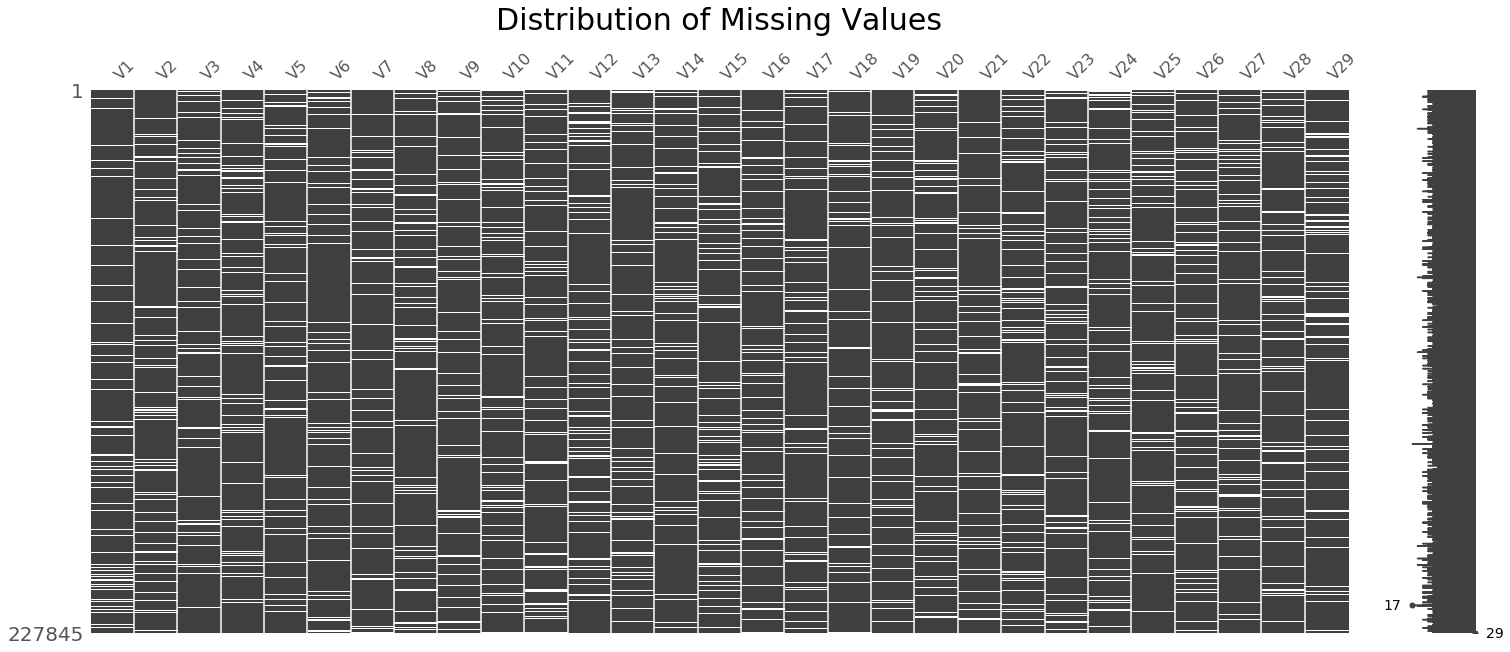

In [14]:
# Missing Value
missingdata_df = train_ead.columns[train_ead.isnull().any()].tolist()
ms_matrix = msno.matrix(train_ead[missingdata_df])
ms_matrix.plot()
plt.title('Distribution of Missing Values', pad = 60, fontdict = {'fontsize': 30})
plt.savefig('images/EDA_ms_matrix.png')
plt.show()

#### The missing value is randomly distributed across dataset and no clear pattern is found.

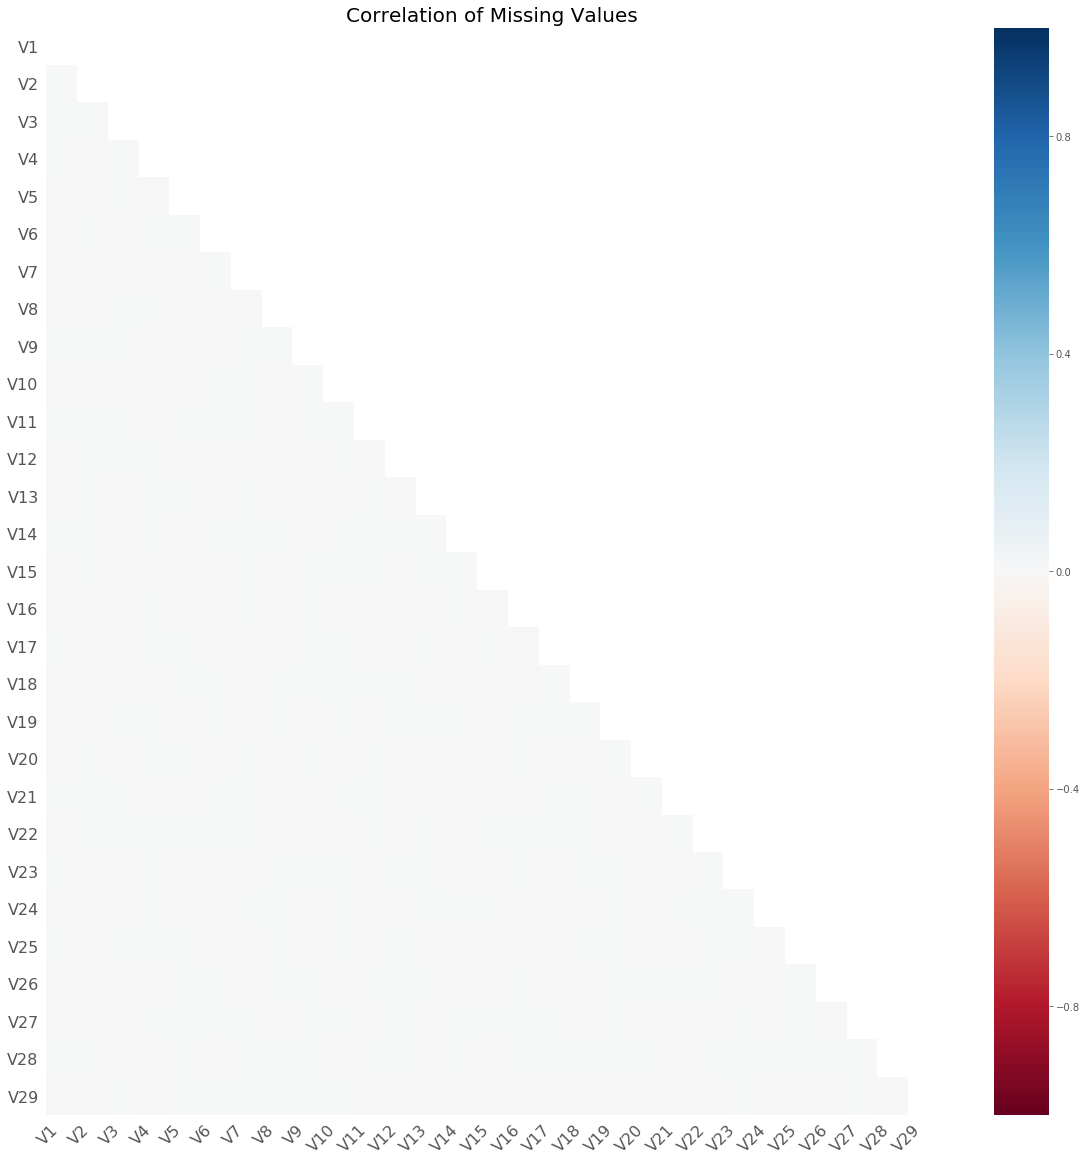

<Figure size 432x288 with 0 Axes>

In [15]:
ms_map = msno.heatmap(train_ead[missingdata_df], figsize=(20,20))
ms_map.plot()
plt.title('Correlation of Missing Values', fontdict = {'fontsize': 20})
plt.show()
plt.savefig('images/EDA_ms_map.png')

#### Nullity correlation is 0, which indicates the abscense of one variable can not affect another.

In [16]:
count_nonnan = train_ead.apply(lambda x: x.count(), axis=1)
test = pd.concat([count_nonnan, train_ead[OUTCOME]], axis=1)
test.corr()

,0,Class
0,1.000000,0.001707
Class,0.001707,1.000000


#### The correlation between number of NaNs in each row and the target variable is nearly 0

#### From the explorations above, the missing values are random. 

#### Choosing imputation function:

1. One can not drop all the NaNs, because the amount of NaNs is relatively large.
2. Simple Imputation is fast, but may not be very accurate due to the amount of NaNs and Outliers.
3. The speed and accuracy of KNN imputation may not be good due to the number of dimensions.
4. Iterative Imputaion is robust and would have slight higher accraucy, but the speed would be much slower compare to simple imputation.

#### One has to balance between speed and accraucy demands when choosing in the upcoming steps

In [19]:
# Prepare data for visualization
imputer = SimpleImputer()
train_filled = pd.DataFrame(imputer.fit_transform(train_ead))
train_filled.columns = train_ead.columns
train_filled.index = train_ead.index

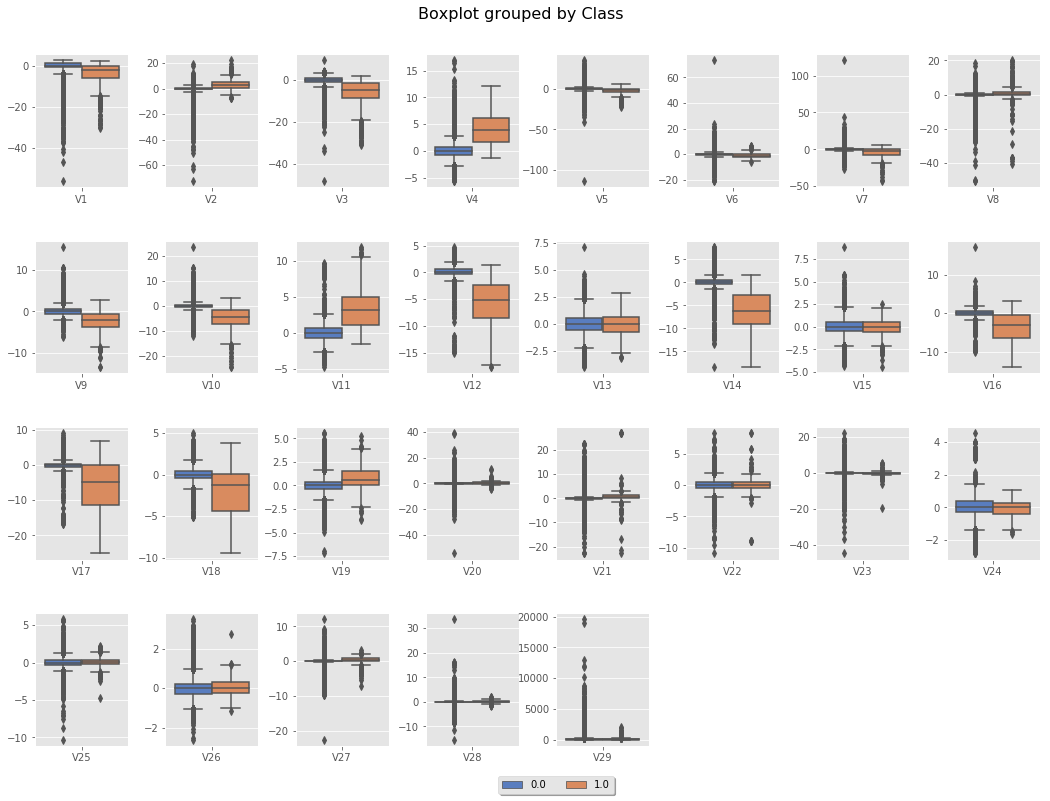

In [20]:
# Distribution of all features - Grouped by Class
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 30):
    ax = fig.add_subplot(4, 8, i)
    target = 'V'+str(i)
    df_melt = train_filled[[target, 'Class']].melt(id_vars='Class', value_vars=target, var_name=target)
    sns.boxplot(data=df_melt, hue=OUTCOME, x=target, y='value', ax=ax, palette='muted')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend_.remove()
plt.suptitle('Boxplot grouped by Class', size=16)
plt.subplots_adjust(top=.925)
plt.legend(loc='lower center', bbox_to_anchor=(0, -0.4), fancybox=True, shadow=True, ncol=2)
fig.set_size_inches(18, 12, forward=True)
fig.show()
fig.savefig('images/EDA_boxplot_features_class.png')

#### The mean of V1-V28 is near 0 when the Class is 0.
#### The shapes of the boxplots of Class 0 and Class 1 are obviously different at some of the features (V11,V12,V14,V17,V18)
#### Features are not in the same scale.
#### Most of the features have outliers, but the distributions of the outliers are different between Classes. The outliers may contain useful information. 

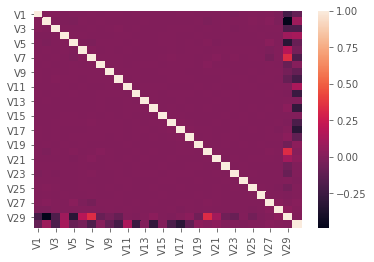

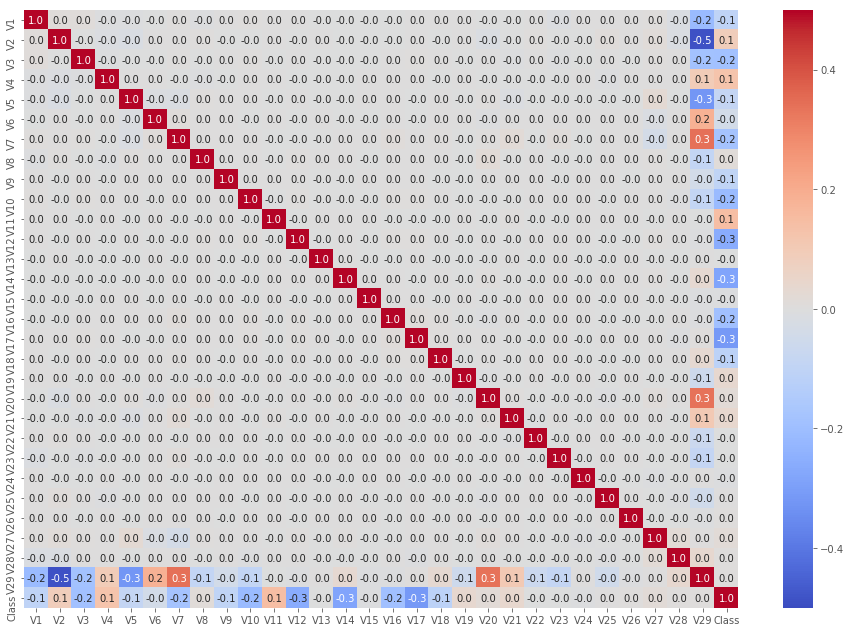

In [21]:
# Correlation between features
corr = train_filled.corr()
sns.heatmap(corr)
fig, ax = plt.subplots(figsize=(16, 11))
sns.heatmap(corr, annot=True, fmt='.1f', cmap='coolwarm', vmin=-0.5, vmax=0.5)
fig.show()
fig.savefig('images/EDA_correlation.png')

#### There were no correlations among V1-V28.
#### V2 and V29 have a relatively high correlation (-0.5).
#### No feature has high correlation with the Class.

In [22]:
# Rank Correlation
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr_rank = get_top_abs_correlations(train_filled, 20)
corr_rank[corr_rank>0.2]

V2   V29      0.487653
V7   V29      0.341620
V20  V29      0.337009
V5   V29      0.322005
V17  Class    0.313617
V14  Class    0.285043
V12  Class    0.258449
V1   V29      0.214491
V10  Class    0.213847
dtype: float64

#### According to the rank of correlations, one has to plot the distribution of the top pairs and explore the patterns

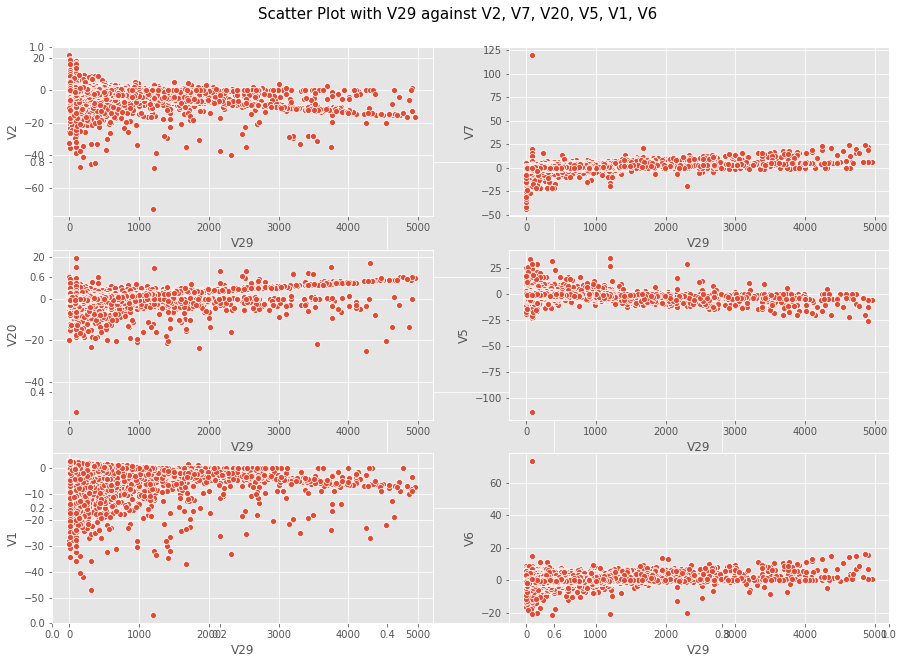

In [23]:
# Take a deeper look into high correlation pairs
# with V29
pairs = ['V2', 'V7', 'V20', 'V5', 'V1', 'V6']
flitered = train_filled[(train_filled['V29']<=5000)&(train_filled['V29']>-700)]
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots()
for i in range(len(pairs)):
    ax = fig.add_subplot(3, 2, i+1)
    sns.scatterplot(x='V29', y=pairs[i], data=flitered[[pairs[i], 'V29']])
plt.suptitle('Scatter Plot with V29 against V2, V7, V20, V5, V1, V6', size=15)
plt.subplots_adjust(top=.925)
fig.set_size_inches(15, 10, forward=True)
fig.show()
fig.savefig('images/EDA_scatterplot_V29.png')

#### Some of the variables above might have a linear relationship with V29, but the relationship is not strong.

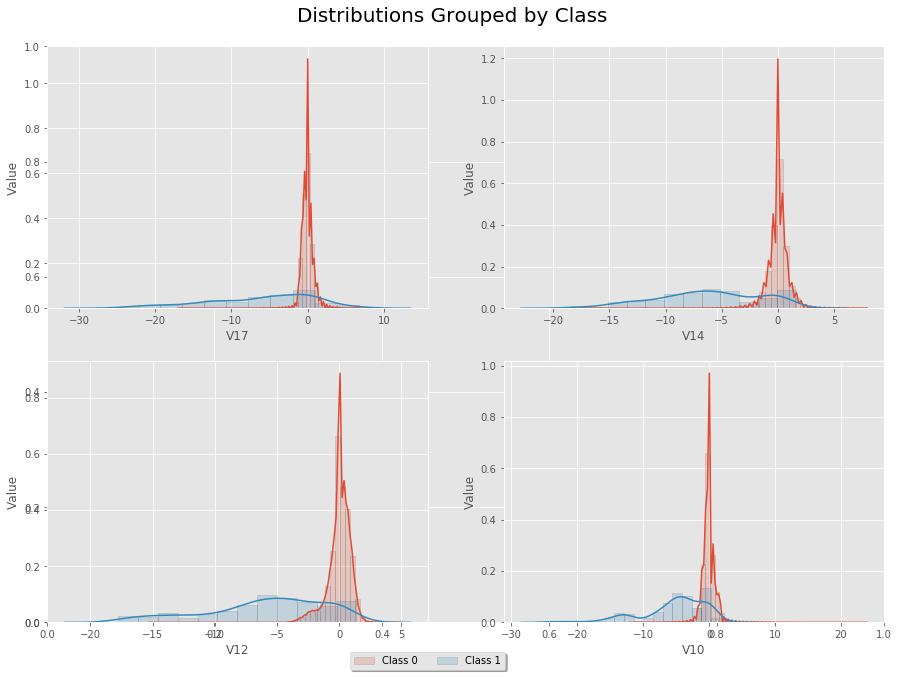

In [24]:
# with Class
pairs = ['V17', 'V14', 'V12', 'V10']
fig, ax = plt.subplots()
for i in range(len(pairs)):
    ax = fig.add_subplot(2, 2, i+1)
    sns.distplot(train_filled[train_filled[OUTCOME]==0][pairs[i]], label='Class 0', ax=ax, hist_kws=hist_kws)
    sns.distplot(train_filled[train_filled[OUTCOME]==1][pairs[i]], label='Class 1', ax=ax, hist_kws=hist_kws)
    ax.set_xlabel(pairs[i])
    ax.set_ylabel('Value')
plt.suptitle('Distributions Grouped by Class', size=20)
plt.subplots_adjust(top=.925)
plt.legend(loc='lower center', bbox_to_anchor=(-0.2, -0.2), fancybox=True, shadow=True, ncol=2)
fig.set_size_inches(15, 10, forward=True)
fig.show()
fig.savefig('images/EDA_dist_class.png')

#### The data is very close to the mean and the mean is nearly 0 when the class is 0
#### The data speard out and the number of data points are small when the class is 1

# Logistic Regression Approach

## Pipeline

In [25]:
pipeline = Pipeline([
    ('imputer', DFSimpleImputer()),
#     ('imputer', DFIterativeImputer()),
    ('scale', DFStandardScaler()),
    ('model', LogisticRegression(class_weight='balanced'))
])

#### Imputer:
    DFSimpleImputer: 
        Defined in the transformer.py. It outputs DataFrame instead of Array. 
        Considering the size of the dataset and cross validation process, simple Imputation will be much faster.
    DFIterativeImputer:
        Defined in the transformer.py. It outputs DataFrame instead of Array. 
        When one has to increase the accuracy of GridSearch result, one can switch to make the result better.
#### Scale:
    DFStandardScaler:
        Defined in the transformer.py. It outputs DataFrame instead of Array.
        Features are not in the same scale, one can add scaler to balance the scale and make the convergence faster.
        The outliers may contain information that can increase the accuracy, so robust methods like RobustScaler would not be a better choice.
#### Model:
    LogisticRegression(class_weight='balanced'):
        There are high number of features and outliers, SVM will be slow.
        Logistic Regression have good performance, higher speed, and high interpretability.
        Set class_weight='balanced' to put more emphasis on Class 1 due to the imbalance of the data.
        Use regularization penalty to select features.

## Tuning

In [26]:
check_params= {
#     'imputer__max_iter': [8, 10, 12],
    'model__C': [0.0001, 0.001, 0.01, 0.1, 1],
    'model__penalty': ['l1','l2']

}
create_grid = RandomizedSearchCV(pipeline, param_distributions=check_params, cv=3, n_jobs=4, scoring='roc_auc', verbose=50)
create_grid.fit(X_train, y_train)
create_grid.score(X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(

0.9686527396552319

#### Parameters:
    imputer__max_iter:
        Parameter of DFIterativeImputer. Maximum number of imputation rounds to perform.
    model__C:
        Parameter of LogisticRegression. Inverse of regularization strength.
        According to the EDA, stronger regulation is needed.
    model__penalty:
        Parameter of LogisticRegression. Specify the norm used in the penalization.
#### RandomizedSearchCV:
    RamdomizedSearch is faster than GridSearch and the performance is as good.
    n_jobs: make 4 jobs to run in parallel to increase the speed of process.
    verbose: set verbose to true to show the prograss.

In [27]:
create_grid.best_params_

{'model__penalty': 'l2', 'model__C': 0.0001}

In [28]:
best_m_lr = create_grid.best_estimator_
best_m_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer', DFSimpleImputer(max_iter=None)),
                ('scale',
                 <transformers.DFStandardScaler object at 0x14a317978>),
                ('model',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='warn',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='warn',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

## Feature Importance

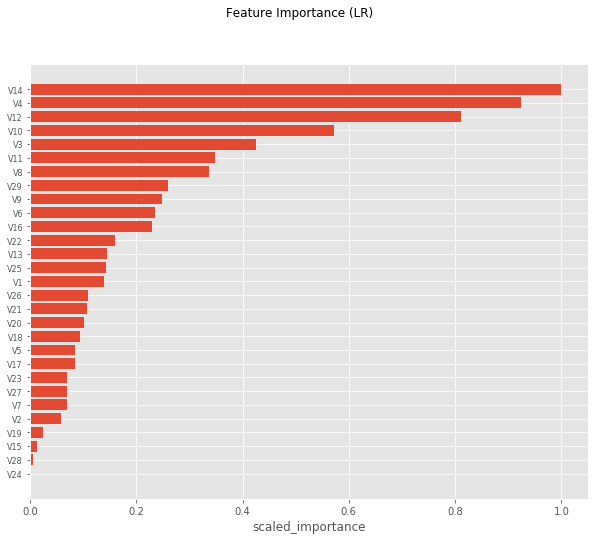

In [29]:
feature_importance = abs(best_m_lr.named_steps['model'].coef_[0])
feature_importance = feature_importance / feature_importance.max()
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
ax.set_xlabel('scaled_importance')
plt.suptitle('Feature Importance (LR)')
plt.show()
fig.savefig('images/LR_feature_importance.png')

#### V14, V4, V12 are the most important features

## Prediction

In [30]:
train_true = y_train
test_true = y_test
train_pred = best_m_lr.predict_proba(X_train)[:, 1]
test_pred = best_m_lr.predict_proba(X_test)[:, 1]

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

## Evaluation

In [31]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.86      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



#### For Class 0:
    The model is good at detecting 0, since precision, recall, and f1-score are close to 1
#### For Class 1:
    Percision: When a class is predicted 1, then only 6% of the times the prediction is right
    Recall: The model detected 86% of all 1s available
    If Class 1 represents the paitient has a disease, the model is conservative in diagnostic

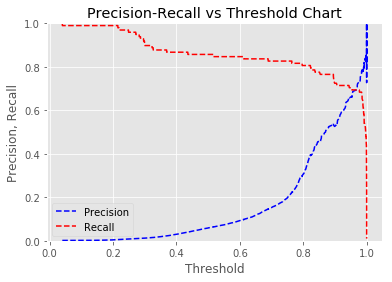

In [32]:
# Threshold Chart
precision, recall, thresholds = precision_recall_curve(test_true, test_pred)
pr_auc = metrics.auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0, 1])
plt.show()
fig.savefig('images/LR_Threshold_Chart.png')

#### If the threshold is lower the precision will be even lower, if the threshold is higher the recall will decrease
#### One can adjust the threshold if different precision and recall are required

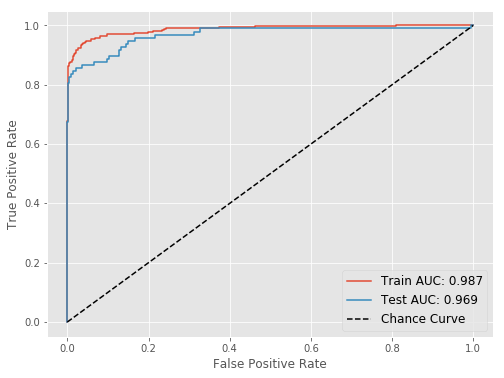

In [33]:
# AUC Curve
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
fig.savefig('images/LR_AUC.png')

#### The Train AUC score is slightly higher than Test AUC score. 
#### There is no sign of overfitting or underfitting.

# H2O Approach

In [59]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,19 mins 24 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,4 months and 15 days !!!
H2O cluster name:,H2O_from_python_lijiahuan_p2oqgk
H2O cluster total nodes:,1
H2O cluster free memory:,1.594 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [60]:
# Perpare dataset
x_feature = list(X_train.columns)
y_feature = OUTCOME
train = pd.concat([X_train, y_train.astype('category')], axis=1)
test = pd.concat([X_test, y_test.astype('category')], axis=1)
train = H2OFrame(train)
train[OUTCOME] = train[OUTCOME].asfactor()
test = H2OFrame(test)
test[OUTCOME] = test[OUTCOME].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## H2O Grid Search

In [61]:
hyper_params = {'ntrees': [10, 20, 30],
                'max_depth': [3, 5, 8, 10],
                'max_after_balance_size': [.85, 1, 1.5]}
criteria = {"strategy": "RandomDiscrete",
            "stopping_rounds": 10,
            "stopping_tolerance": 0.00001,
            "stopping_metric": "auc"}
model = H2OGridSearch(model=H2ORandomForestEstimator(balance_classes=True),
                      hyper_params=hyper_params,
                      search_criteria=criteria)
model.train(x=x_feature, y=y_feature, training_frame=train, validation_frame=test)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


#### Model:
    H2ORandomForestEstimator is faster, robust, and good at handle imbalance data.
#### Parameters:
    balance_classes: Set to True to oversample Class 1.
    max_after_balance_size: Reset the size of training set after oversample Class 1.
    ntrees: Number of trees. Set small values to avoid overfitting. 
    max_depth: Maximum tree depth. Set small values to avoid overfitting. 

In [62]:
best_m_h2o = model.get_grid(sort_by='auc', decreasing=True).models[0]
best_m_h2o

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  Grid_DRF_py_5_sid_9973_model_python_1569176316884_1398_model_34


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.16981148680873376
RMSE: 0.41208189332793277
LogLoss: 0.7264103588276667
Mean Per-Class Error: 0.017018444670568122
AUC: 0.9974172762576029
pr_auc: 0.997941104310125
Gini: 0.9948345525152058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0010711409079783654: 


,0,1,Error,Rate
0,169173.0,1651.0,0.0097,(1651.0/170824.0)
1,4164.0,166688.0,0.0244,(4164.0/170852.0)
Total,173337.0,168339.0,0.017,(5815.0/341676.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0010711,0.9828563,396.0
max f2,0.0005693,0.9866320,397.0
max f0point5,0.0016094,0.9882204,395.0
max accuracy,0.0010711,0.9829810,396.0
max precision,1.0,1.0,0.0
max recall,0.0000717,1.0,399.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.0010711,0.9660665,396.0
max min_per_class_accuracy,0.0010711,0.9756280,396.0
max mean_per_class_accuracy,0.0010711,0.9829816,396.0


Gains/Lift Table: Avg response rate: 50.01 %, avg score: 24.46 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100024,0.7829002,1.9997718,1.9997718,1.0,0.8148494,1.0,0.8148494,0.0200026,0.0200026,99.9771767,99.9771767
,2,0.0200019,0.7612298,1.9986013,1.9991866,0.9994147,0.7709209,0.9997074,0.7928884,0.0199850,0.0399876,99.8601283,99.9186611
,3,0.0300014,0.7482897,1.9991865,1.9991866,0.9997073,0.7542581,0.9997074,0.7800129,0.0199909,0.0599785,99.9186525,99.9186582
,4,0.0400009,0.7390176,1.9997718,1.9993329,1.0,0.7434317,0.9997805,0.7708683,0.0199967,0.0799752,99.9771767,99.9332868
,5,0.0500004,0.7313903,1.9991865,1.9993036,0.9997073,0.7351419,0.9997659,0.7637234,0.0199909,0.0999661,99.9186525,99.9303601
,6,0.1000009,0.7046739,1.9995377,1.9994206,0.9998829,0.7169669,0.9998244,0.7403452,0.0999778,0.1999438,99.9537684,99.9420642
,7,0.1500013,0.6850976,1.9991866,1.9993426,0.9997074,0.6945754,0.9997854,0.7250886,0.0999602,0.2999040,99.9186559,99.9342615
,8,0.2000018,0.6658925,1.9994206,1.9993621,0.9998244,0.6755694,0.9997952,0.7127088,0.0999719,0.3998759,99.9420642,99.9362122
,9,0.2999997,0.5981470,1.9990695,1.9992646,0.9996488,0.6392434,0.9997464,0.6882208,0.1999029,0.5997788,99.9069497,99.9264582
,10,0.4000006,0.1009959,1.9991280,1.9992304,0.9996781,0.3601247,0.9997293,0.6061962,0.1999146,0.7996933,99.9128039,99.9230446




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.0010087373950524378
RMSE: 0.031760626490238475
LogLoss: 0.005742513517540308
Mean Per-Class Error: 0.08552809137160766
AUC: 0.9767156581259403
pr_auc: 0.672029949683255
Gini: 0.9534313162518806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.009603146362789191: 


,0,1,Error,Rate
0,56850.0,14.0,0.0002,(14.0/56864.0)
1,29.0,69.0,0.2959,(29.0/98.0)
Total,56879.0,83.0,0.0008,(43.0/56962.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0096031,0.7624309,54.0
max f2,0.0025063,0.7623762,80.0
max f0point5,0.0096031,0.8023256,54.0
max accuracy,0.0096031,0.9992451,54.0
max precision,0.7149009,1.0,0.0
max recall,0.0001153,1.0,315.0
max specificity,0.7149009,1.0,0.0
max absolute_mcc,0.0096031,0.7646943,54.0
max min_per_class_accuracy,0.0002083,0.9008687,262.0
max mean_per_class_accuracy,0.0003001,0.9144719,229.0


Gains/Lift Table: Avg response rate:  0.17 %, avg score:  0.08 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100067,0.0007024,82.5979592,82.5979592,0.1421053,0.0681175,0.1421053,0.0681175,0.8265306,0.8265306,8159.7959184,8159.7959184
,2,0.0200133,0.0004845,1.0197279,41.8088435,0.0017544,0.0005785,0.0719298,0.0343480,0.0102041,0.8367347,1.9727891,4080.8843537
,3,0.0300025,0.0003952,0.0,27.8888716,0.0,0.0004359,0.0479813,0.0230572,0.0,0.8367347,-100.0,2688.8871640
,4,0.0400091,0.0003369,1.0197279,21.1686382,0.0017544,0.0003632,0.0364195,0.0173812,0.0102041,0.8469388,1.9727891,2016.8638232
,5,0.0500158,0.0002986,3.0591837,17.5454760,0.0052632,0.0003171,0.0301860,0.0139672,0.0306122,0.8775510,205.9183673,1654.5476035
,6,0.1000140,0.0002073,0.6122664,9.0803574,0.0010534,0.0002449,0.0156223,0.0071072,0.0306122,0.9081633,-38.7733605,808.0357367
,7,0.1500123,0.0001656,0.6122664,6.2579907,0.0010534,0.0001841,0.0107665,0.0047998,0.0306122,0.9387755,-38.7733605,525.7990709
,8,0.2000105,0.0001415,0.2040888,4.7446481,0.0003511,0.0001527,0.0081629,0.0036381,0.0102041,0.9489796,-79.5911202,374.4648074
,9,0.3000070,0.0001105,0.5102220,3.3332553,0.0008778,0.0001247,0.0057347,0.0024671,0.0510204,1.0,-48.9778004,233.3255310
,10,0.4000035,0.0000904,0.0,2.4999781,0.0,0.0000995,0.0043011,0.0018752,0.0,1.0,-100.0,149.9978056



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-09-22 14:41:49,3 min 8.103 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-09-22 14:41:50,3 min 8.811 sec,1.0,0.3460881,0.6307375,0.9850252,0.9565222,1.9993225,0.0402000,0.0284366,0.0113767,0.8536470,0.0932376,67.0667190,0.0008778
,2019-09-22 14:41:50,3 min 9.051 sec,2.0,0.3537698,0.6405690,0.9854997,0.9589964,1.9997718,0.0365358,0.0286694,0.0071667,0.9054577,0.6440662,76.4795918,0.0008251
,2019-09-22 14:41:50,3 min 9.305 sec,3.0,0.3668927,0.6626400,0.9861735,0.9663605,1.9997718,0.0363802,0.0291721,0.0066048,0.9095671,0.6460288,79.2606679,0.0008427
,2019-09-22 14:41:51,3 min 9.582 sec,4.0,0.3743883,0.6661787,0.9905247,0.9776433,1.9993156,0.0338658,0.0302444,0.0063959,0.9374067,0.5774943,81.4547348,0.0008953
,2019-09-22 14:41:51,3 min 9.941 sec,5.0,0.3841064,0.6768103,0.9926916,0.9795280,1.9991886,0.0306604,0.0309086,0.0065747,0.9412800,0.5845273,82.5979592,0.0010007
,2019-09-22 14:41:52,3 min 10.390 sec,6.0,0.3914505,0.6852383,0.9933566,0.9853965,1.9986595,0.0282859,0.0311123,0.0060815,0.9498825,0.6330662,81.3140531,0.0008953
,2019-09-22 14:41:52,3 min 10.887 sec,7.0,0.3885923,0.6711706,0.9953579,0.9883021,1.9980504,0.0261101,0.0311610,0.0057100,0.9554315,0.6315979,82.5979592,0.0008251
,2019-09-22 14:41:53,3 min 11.401 sec,8.0,0.3949686,0.6801284,0.9957416,0.9904497,1.9986057,0.0239899,0.0313731,0.0057523,0.9570134,0.6855109,82.5979592,0.0008427
,2019-09-22 14:41:53,3 min 11.915 sec,9.0,0.3906355,0.6798473,0.9955684,0.9908402,1.9991909,0.0246303,0.0312982,0.0057044,0.9631513,0.6558642,82.5979592,0.0008251


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
V14,375002.8750000,1.0,0.2924751
V12,188036.5156250,0.5014269,0.1466549
V17,173722.6406250,0.4632568,0.1354911
V4,169796.6250000,0.4527875,0.1324291
V16,86569.1796875,0.2308494,0.0675177
---,---,---,---
V27,2232.3764648,0.0059530,0.0017411
V25,2079.4208984,0.0055451,0.0016218
V24,1756.2844238,0.0046834,0.0013698
V28,1634.8278809,0.0043595,0.0012750



See the whole table with table.as_data_frame()


In [63]:
keys = ['ntrees', 'max_depth', 'max_after_balance_size']
[(key, best_m_h2o.actual_params[key]) for key in keys]

[('ntrees', 20), ('max_depth', 8), ('max_after_balance_size', 1.5)]

## Feature Importance

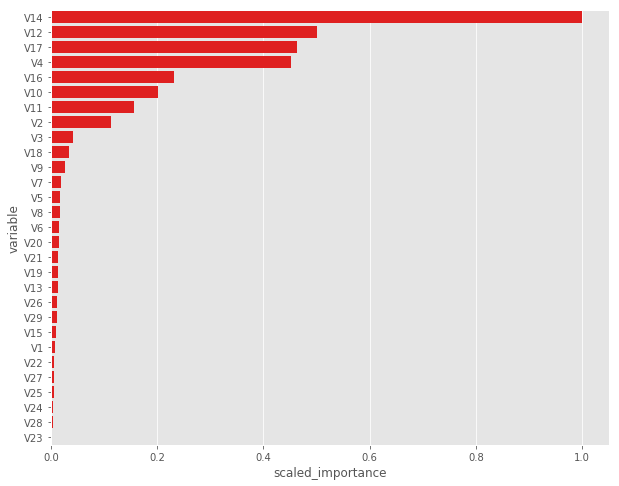

In [64]:
importance = best_m_h2o.varimp(use_pandas=True)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance, color='red')
plt.show()
fig.savefig('images/H2O_feature_importance.png')

#### V14 is the most important feature
#### Half of the features have nearly 0 scaled importance

## Prediction

In [65]:
from sklearn.metrics import auc, roc_curve, classification_report

train_true = train.as_data_frame()[OUTCOME].values
test_true = test.as_data_frame()[OUTCOME].values
train_pred = best_m_h2o.predict(train).as_data_frame()['p1'].values
test_pred = best_m_h2o.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


## Evaluation

In [66]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.47      0.61        98

    accuracy                           1.00     56962
   macro avg       0.93      0.73      0.80     56962
weighted avg       1.00      1.00      1.00     56962



#### For Class 0:
    The model is good at detecting 0, since precision, recall, and f1-score are 1
#### For Class 1:
    Percision: When a class is predicted 1, then 85% of the times the prediction is right
    Recall: The model detected 47% of all 1s available
    If Class 1 represents the paitient has a disease, patients who have the disease have a high chance not be detected in this model.

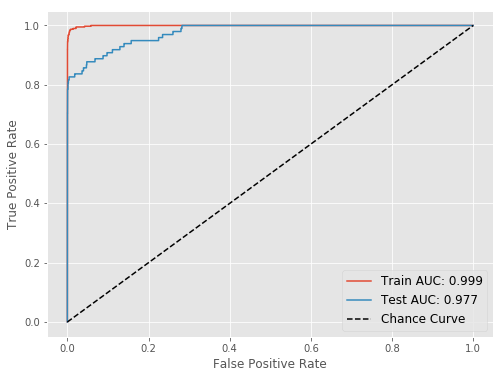

In [67]:
# AUC Curve
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()
fig.savefig('images/H2O_AUC.png')

In [68]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_9973 closed.


#### Comparison of Two Approaches: 
    The H2O approach is generally better
    1. H2O approach is easy: it do not need to handle the missing values and easy to implement.
    2. H2O approach is fast
    3. H2O approach has high AUC score: H20-0.977, LR-0.969
    
    Practical Application of Models
    LR approach has low presicion and high recall
    H2O approach has high presiocion and low recall
    The two approaches can be used in different cases